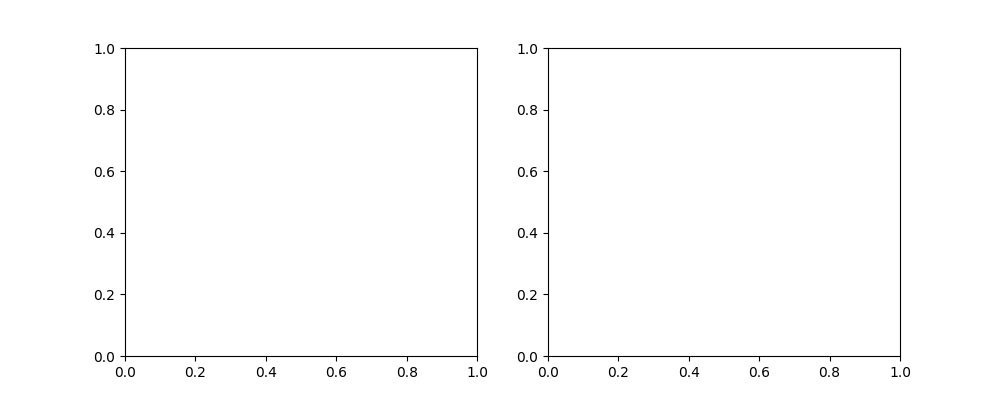

In [8]:
%matplotlib widget
import rospy
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from assignment_2_2024.msg import RobotState
from geometry_msgs.msg import Point
from std_msgs.msg import Float32

# Initialize ROS node
rospy.init_node('jupyter_frontend', anonymous=True)

# Global state variables
robot_position = (0.0, 0.0)
obstacle_distance = 0.0
target_position = None
reached_count = 0
cancelled_count = 0

# ROS Publishers
goal_pub = rospy.Publisher('/goal_topic', Point, queue_size=10)
cancel_pub = rospy.Publisher('/cancel_goal_topic', Float32, queue_size=1)

# ROS Subscribers
def robot_state_callback(msg):
    global robot_position
    robot_position = (msg.x, msg.y)

def obstacle_callback(msg):
    global obstacle_distance
    obstacle_distance = msg.data

def goal_result_callback(msg):
    global reached_count, cancelled_count, target_position
    if msg.data == 1.0:
        reached_count += 1
    else:
        cancelled_count += 1
    target_position = None

rospy.Subscriber('/robot_state', RobotState, robot_state_callback)
rospy.Subscriber('/obstacle_distance', Float32, obstacle_callback)
rospy.Subscriber('/goal_result', Float32, goal_result_callback)

# Widgets
goal_x = widgets.FloatSlider(value=0.0, min=-5, max=5, step=1, description="Goal X:")
goal_y = widgets.FloatSlider(value=0.0, min=-5, max=5, step=1, description="Goal Y:")
send_btn = widgets.Button(description="Send Goal", button_style='success')
cancel_btn = widgets.Button(description="Cancel Goal", button_style='danger')
status_label = widgets.Label()

# Goal handling
def send_goal(x, y):
    goal_msg = Point(x=x, y=y, z=0.0)
    goal_pub.publish(goal_msg)
    global target_position
    target_position = (x, y)
    status_label.value = f"Goal published: ({x:.1f}, {y:.1f})"

def cancel_goal():
    cancel_pub.publish(Float32(1.0))  # Trigger backend cancellation
    global target_position
    target_position = None
    status_label.value = "Goal canceled (backend notified)"

send_btn.on_click(lambda _: send_goal(goal_x.value, goal_y.value))
cancel_btn.on_click(lambda _: cancel_goal())

# Display interface
display(widgets.VBox([
    goal_x, goal_y, send_btn, cancel_btn, status_label
]))

# Plotting
fig, (ax_pos, ax_bar) = plt.subplots(1, 2, figsize=(10, 4))

def update_plot(_):
    ax_pos.clear()
    ax_pos.set_xlim(-5, 5)
    ax_pos.set_ylim(-5, 5)
    ax_pos.set_title(f"Robot & Target - Obstacle: {obstacle_distance:.2f}m")
    ax_pos.scatter(*robot_position, c='blue', label='Robot')
    if target_position:
        ax_pos.scatter(*target_position, c='red', label='Target')
    ax_pos.legend()

    ax_bar.clear()
    ax_bar.set_title("Goals Summary")
    ax_bar.bar(["Reached", "Canceled"], [reached_count, cancelled_count], color=["green", "gray"])
    ax_bar.set_ylim(0, max(1, reached_count + cancelled_count + 1))

_ = plt.show()
ani = FuncAnimation(fig, update_plot, interval=500, cache_frame_data=False)


In [9]:
import sys
sys.path.append('/home/ts/2/devel/lib/python3/dist-packages')
